Runs: 100, FCC z half-period ≈ 35.355, max shift used ±17.678
Cells per run (after full-sphere filtering): min=42540, max=42620, mean=42582.6


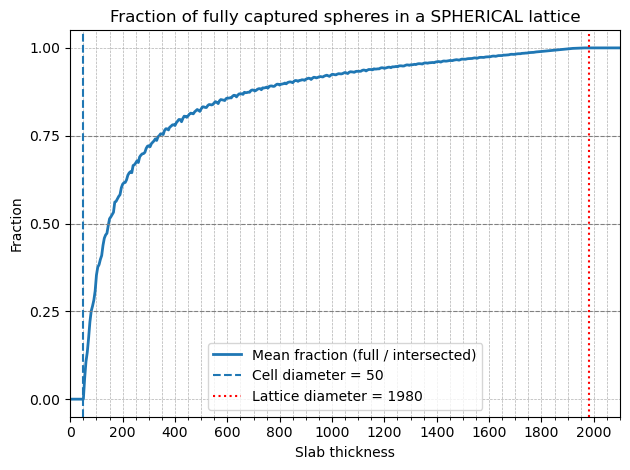

In [10]:
"""
FCC Sphere Sectioning Simulation for Variable Slab Thickness.

This script simulates the sectioning of a 3D volume of spheres arranged
in a Face-Centered Cubic (FCC) lattice. It calculates the fraction of spheres
fully captured versus those merely intersected by a central slab of varying
thickness.

The lattice of spheres is contained within a large sphere, not a cube.

Acknowledgements:
The code for these simulations was mainly generated with assistance from
AI models, including ChatGPT 5 and GeminiPro 2.5.
"""

import numpy as np
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ----------------- FCC lattice -----------------

@dataclass
class LatticeConfig:
    Lx: float = 1000.0
    Ly: float = 1000.0
    Lz: float = 1000.0
    sphere_radius: float = 15.0  # diameter 30
    # --- MODIFIED: Added radius for the overall spherical shape of the lattice ---
    lattice_radius: float = 500.0 # The overall lattice will be a sphere of this radius

def fcc_unit_cell_spacing(R: float) -> float:
    # Touching spheres in FCC: a/√2 = 2R -> a = 2√2 R
    return 2.0 * math.sqrt(2.0) * R

def build_fcc_centers(cfg: LatticeConfig) -> np.ndarray:
    """Generate FCC sphere centers inside a large sphere."""
    R = cfg.sphere_radius
    a = fcc_unit_cell_spacing(R)

    # First, generate points in a box large enough to contain the sphere
    nx = int(math.ceil(cfg.Lx / a)) + 1
    ny = int(math.ceil(cfg.Ly / a)) + 1
    nz = int(math.ceil(cfg.Lz / a)) + 1

    bases = np.array([
        [0.0, 0.0, 0.0],
        [0.0, a/2, a/2],
        [a/2, 0.0, a/2],
        [a/2, a/2, 0.0],
    ], dtype=float)

    gx = np.arange(nx) * a
    gy = np.arange(ny) * a
    gz = np.arange(nz) * a

    pts = []
    for x in gx:
        for y in gy:
            for z in gz:
                origin = np.array([x, y, z], dtype=float)
                pts.append(bases + origin)
    centers = np.concatenate(pts, axis=0)

    # --- MODIFIED: Filter points to be inside a sphere, not a box ---
    lattice_center = np.array([cfg.Lx/2, cfg.Ly/2, cfg.Lz/2])
    dist_sq = np.sum((centers - lattice_center)**2, axis=1)
    mask = dist_sq <= cfg.lattice_radius**2
    return centers[mask]

def keep_full_spheres_only(centers: np.ndarray, cfg: LatticeConfig) -> np.ndarray:
    """Filter centers so the entire small sphere fits in the large lattice sphere."""
    # --- MODIFIED: The condition now checks if a small sphere is fully inside the large sphere ---
    R_small = cfg.sphere_radius
    R_large = cfg.lattice_radius
    lattice_center = np.array([cfg.Lx/2, cfg.Ly/2, cfg.Lz/2])

    dist_sq = np.sum((centers - lattice_center)**2, axis=1)
    # A small sphere is "full" if its center is no further than R_large - R_small from the lattice center
    safe_radius_sq = (R_large - R_small)**2
    mask_full = dist_sq <= safe_radius_sq
    return centers[mask_full]


# ----------------- Metric for a centered slab -----------------

def frac_full_over_intersected_centered(centers: np.ndarray,
                                        cfg: LatticeConfig,
                                        thicknesses: np.ndarray) -> np.ndarray:
    """Compute fraction(full/intersected) for a centered slab for all thicknesses."""
    zc = centers[:, 2].astype(float)
    R = cfg.sphere_radius
    frac = np.full_like(thicknesses, np.nan, dtype=float)

    for i, t in enumerate(thicknesses.astype(float)):
        # The slab is still a flat plane, centered at Lz/2
        z0 = 0.5 * (cfg.Lz - t)
        z1 = z0 + t
        inter = (zc + R > z0) & (zc - R < z1)
        full  = (zc >= z0 + R) & (zc <= z1 - R)
        ni = inter.sum()
        nf = full.sum()
        frac[i] = (nf / ni) if ni > 0 else np.nan
    return frac

# ----------------- Multi-run with small z-shifts -----------------

def multi_run_shifted(cfg: LatticeConfig,
                      thicknesses: np.ndarray,
                      K: int = 50,
                      seed: int = 0,
                      max_shift_fraction: float = 0.5):
    """
    Run K repeats. Each repeat applies a small z-shift to all centers, then filters
    to keep full spheres, then computes the centered-slab fraction curve.
    """
    rng = np.random.default_rng(seed)
    base = build_fcc_centers(cfg)

    a = fcc_unit_cell_spacing(cfg.sphere_radius)
    z_period = a / 2.0
    max_shift = max_shift_fraction * z_period

    curves = []
    Ns = []
    for k in range(K):
        dz = rng.uniform(-max_shift, max_shift)
        shifted = base.copy()
        shifted[:, 2] = shifted[:, 2] + dz

        # This will now filter based on the spherical boundary
        shifted_full = keep_full_spheres_only(shifted, cfg)

        Ns.append(shifted_full.shape[0])
        curves.append(frac_full_over_intersected_centered(shifted_full, cfg, thicknesses))

    curves = np.vstack(curves)
    mean_frac = np.nanmean(curves, axis=0)
    std_frac  = np.nanstd(curves, axis=0, ddof=1) if K > 1 else np.zeros_like(mean_frac)

    return {
        "thickness": thicknesses,
        "mean_fraction": mean_frac,
        "std_fraction": std_frac,
        "all_curves": curves,
        "runs_cell_counts": np.array(Ns),
        "radius": cfg.sphere_radius,
        "Lz": cfg.Lz,
        "K": K,
        "z_period": z_period,
        "max_shift": max_shift,
    }

# ----------------- Example run & plot -----------------

if __name__ == "__main__":
    cfg = LatticeConfig(
        Lx=2000.0, Ly=2000.0, Lz=2000.0,
        sphere_radius=25.0, lattice_radius=990.0
    )

    thicknesses = np.arange(0, 2101, 5, dtype=float)

    res = multi_run_shifted(cfg, thicknesses, K=100, seed=42, max_shift_fraction=0.5)

    print(f"Runs: {res['K']}, FCC z half-period ≈ {res['z_period']:.3f}, max shift used ±{res['max_shift']:.3f}")
    print(f"Cells per run (after full-sphere filtering): min={res['runs_cell_counts'].min()}, "
          f"max={res['runs_cell_counts'].max()}, mean={res['runs_cell_counts'].mean():.1f}")

    # Plot mean ± SD
    diameter = 2.0 * res["radius"]
    Lz = res["Lz"]

    fig, ax = plt.subplots()
    ax.plot(res["thickness"], res["mean_fraction"], linewidth=2, label="Mean fraction (full / intersected)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(0, 2100)
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    for y_val in [0.25, 0.5, 0.75]:
        ax.axhline(y=y_val, color='grey', linestyle='--', linewidth=0.8)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.axvline(diameter, linestyle="--", label=f"Cell diameter = {diameter:g}")
    ax.axvline(2 * cfg.lattice_radius, color='red', linestyle=":", label=f"Lattice diameter = {2*cfg.lattice_radius:g}")
    ax.set_xlabel("Slab thickness")
    ax.set_ylabel("Fraction")
    ax.set_title("Fraction of fully captured spheres in a SPHERICAL lattice")
    ax.legend()
    fig.tight_layout()
    plt.show()

Runs: 100, FCC z half-period ≈ 35.355, max shift used ±17.678
Cells per run (after full-sphere filtering): min=42540, max=42620, mean=42582.6

Plotting all 45985 points for the 3D view. This may be slow...


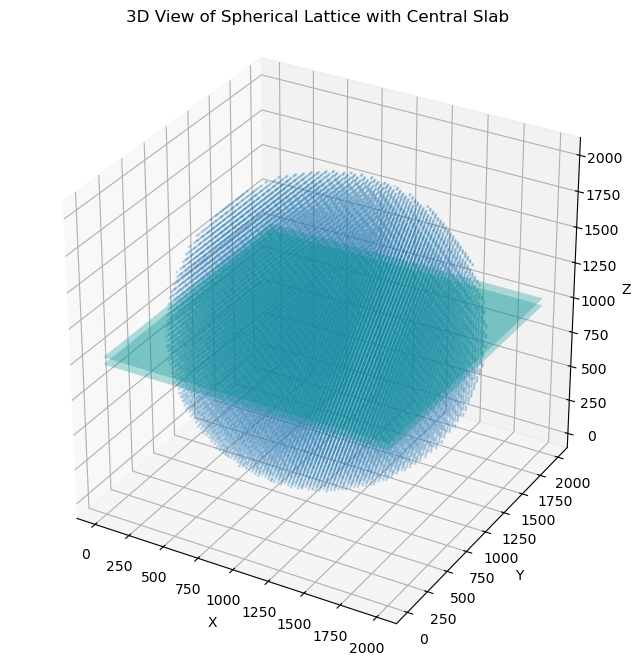

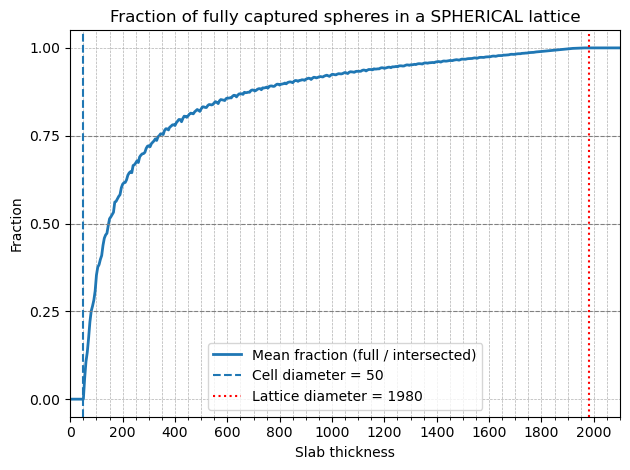

In [18]:
"""
FCC Sphere Sectioning Simulation for Variable Slab Thickness.

This script simulates the sectioning of a 3D volume of spheres arranged
in a Face-Centered Cubic (FCC) lattice. It calculates the fraction of spheres
fully captured versus those merely intersected by a central slab of varying
thickness.

The lattice of spheres is contained within a large sphere, not a cube.
It also includes a 3D visualization of the generated lattice structure
and the central analysis slab.

Acknowledgements:
The code for these simulations was mainly generated with assistance from
AI models, including ChatGPT 5 and GeminiPro 2.5.
"""

import numpy as np
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ----------------- FCC lattice -----------------

@dataclass
class LatticeConfig:
    Lx: float = 1000.0
    Ly: float = 1000.0
    Lz: float = 1000.0
    sphere_radius: float = 15.0  # diameter 30
    lattice_radius: float = 500.0

def fcc_unit_cell_spacing(R: float) -> float:
    return 2.0 * math.sqrt(2.0) * R

def build_fcc_centers(cfg: LatticeConfig) -> np.ndarray:
    """Generate FCC sphere centers inside a large sphere."""
    R = cfg.sphere_radius
    a = fcc_unit_cell_spacing(R)

    nx = int(math.ceil(cfg.Lx / a)) + 1
    ny = int(math.ceil(cfg.Ly / a)) + 1
    nz = int(math.ceil(cfg.Lz / a)) + 1

    bases = np.array([
        [0.0, 0.0, 0.0], [0.0, a/2, a/2],
        [a/2, 0.0, a/2], [a/2, a/2, 0.0],
    ], dtype=float)

    gx, gy, gz = np.arange(nx) * a, np.arange(ny) * a, np.arange(nz) * a

    pts = [bases + np.array([x, y, z], dtype=float)
           for x in gx for y in gy for z in gz]
    centers = np.concatenate(pts, axis=0)

    lattice_center = np.array([cfg.Lx/2, cfg.Ly/2, cfg.Lz/2])
    dist_sq = np.sum((centers - lattice_center)**2, axis=1)
    mask = dist_sq <= cfg.lattice_radius**2
    return centers[mask]

def keep_full_spheres_only(centers: np.ndarray, cfg: LatticeConfig) -> np.ndarray:
    """Filter centers so the entire small sphere fits in the large lattice sphere."""
    R_small, R_large = cfg.sphere_radius, cfg.lattice_radius
    lattice_center = np.array([cfg.Lx/2, cfg.Ly/2, cfg.Lz/2])
    dist_sq = np.sum((centers - lattice_center)**2, axis=1)
    safe_radius_sq = (R_large - R_small)**2
    return centers[dist_sq <= safe_radius_sq]

# ----------------- Metric for a centered slab -----------------

def frac_full_over_intersected_centered(centers: np.ndarray,
                                        cfg: LatticeConfig,
                                        thicknesses: np.ndarray) -> np.ndarray:
    """Compute fraction(full/intersected) for a centered slab for all thicknesses."""
    zc, R = centers[:, 2].astype(float), cfg.sphere_radius
    frac = np.full_like(thicknesses, np.nan, dtype=float)

    for i, t in enumerate(thicknesses.astype(float)):
        z0, z1 = 0.5 * (cfg.Lz - t), 0.5 * (cfg.Lz + t)
        inter = (zc + R > z0) & (zc - R < z1)
        full = (zc >= z0 + R) & (zc <= z1 - R)
        ni, nf = inter.sum(), full.sum()
        frac[i] = (nf / ni) if ni > 0 else np.nan
    return frac

# ----------------- Multi-run with small z-shifts -----------------

def multi_run_shifted(cfg: LatticeConfig,
                      thicknesses: np.ndarray,
                      K: int = 50,
                      seed: int = 0,
                      max_shift_fraction: float = 0.5):
    """Run K repeats with random z-shifts and compute the mean fraction curve."""
    rng, base = np.random.default_rng(seed), build_fcc_centers(cfg)
    a = fcc_unit_cell_spacing(cfg.sphere_radius)
    max_shift = max_shift_fraction * (a / 2.0)

    curves, Ns = [], []
    for _ in range(K):
        dz = rng.uniform(-max_shift, max_shift)
        shifted = base.copy()
        shifted[:, 2] += dz
        shifted_full = keep_full_spheres_only(shifted, cfg)
        Ns.append(shifted_full.shape[0])
        curves.append(frac_full_over_intersected_centered(shifted_full, cfg, thicknesses))

    curves = np.vstack(curves)
    mean_frac = np.nanmean(curves, axis=0)
    std_frac = np.nanstd(curves, axis=0, ddof=1) if K > 1 else np.zeros_like(mean_frac)

    return {"thickness": thicknesses, "mean_fraction": mean_frac,
            "std_fraction": std_frac, "runs_cell_counts": np.array(Ns),
            "radius": cfg.sphere_radius, "Lz": cfg.Lz, "K": K,
            "z_period": a / 2.0, "max_shift": max_shift, "base_centers": base}

# ----------------- Example run & plots -----------------

if __name__ == "__main__":
    cfg = LatticeConfig(
        Lx=2000.0, Ly=2000.0, Lz=2000.0,
        sphere_radius=25.0, lattice_radius=990.0
    )
    thicknesses = np.arange(0, 2101, 5, dtype=float)

    res = multi_run_shifted(cfg, thicknesses, K=100, seed=42, max_shift_fraction=0.5)

    print(f"Runs: {res['K']}, FCC z half-period ≈ {res['z_period']:.3f}, max shift used ±{res['max_shift']:.3f}")
    print(f"Cells per run (after full-sphere filtering): min={res['runs_cell_counts'].min()}, "
          f"max={res['runs_cell_counts'].max()}, mean={res['runs_cell_counts'].mean():.1f}")

    # --- 3D Scatter Plot of Lattice, with Slab Visualization ---

    all_centers = res["base_centers"]
    print(f"\nPlotting all {all_centers.shape[0]} points for the 3D view. This may be slow...")

    fig_3d = plt.figure(figsize=(8, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')

    # Plot ALL the lattice points
    ax_3d.scatter(all_centers[:, 0], all_centers[:, 1], all_centers[:, 2], s=1, alpha=0.2, label='FCC Lattice Points')

    # --- NEW: Draw the central slab ---
    slab_thickness_vis = 50.0
    z_center = cfg.Lz / 2.0
    z0_slab = z_center - slab_thickness_vis / 2.0
    z1_slab = z_center + slab_thickness_vis / 2.0

    # Create grid for the planes
    plane_size = cfg.lattice_radius * 2
    plane_center = np.array([cfg.Lx/2, cfg.Ly/2])
    xx, yy = np.meshgrid(
        np.linspace(plane_center[0] - plane_size/2, plane_center[0] + plane_size/2, 2),
        np.linspace(plane_center[1] - plane_size/2, plane_center[1] + plane_size/2, 2)
    )

    # Plot the top and bottom planes of the slab
    ax_3d.plot_surface(xx, yy, np.full_like(xx, z0_slab), color='c', alpha=0.3, label=f'Slab (t={slab_thickness_vis})')
    ax_3d.plot_surface(xx, yy, np.full_like(xx, z1_slab), color='c', alpha=0.3)

    ax_3d.set_xlabel('X')
    ax_3d.set_ylabel('Y')
    ax_3d.set_zlabel('Z')
    ax_3d.set_title('3D View of Spherical Lattice with Central Slab')
    ax_3d.set_aspect('equal', adjustable='box')

    # --- Original 2D Plot of the Simulation Results ---

    diameter = 2.0 * res["radius"]
    fig, ax = plt.subplots()
    ax.plot(res["thickness"], res["mean_fraction"], linewidth=2, label="Mean fraction (full / intersected)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlim(0, 2100)
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(MultipleLocator(50))

    for y_val in [0.25, 0.5, 0.75]:
        ax.axhline(y=y_val, color='grey', linestyle='--', linewidth=0.8)
    ax.set_yticks(np.arange(0, 1.01, 0.25))

    ax.axvline(diameter, linestyle="--", label=f"Cell diameter = {diameter:g}")
    ax.axvline(2 * cfg.lattice_radius, color='red', linestyle=":", label=f"Lattice diameter = {2*cfg.lattice_radius:g}")

    ax.set_xlabel("Slab thickness")
    ax.set_ylabel("Fraction")
    ax.set_title("Fraction of fully captured spheres in a SPHERICAL lattice")
    ax.legend()
    fig.tight_layout()

    plt.show()

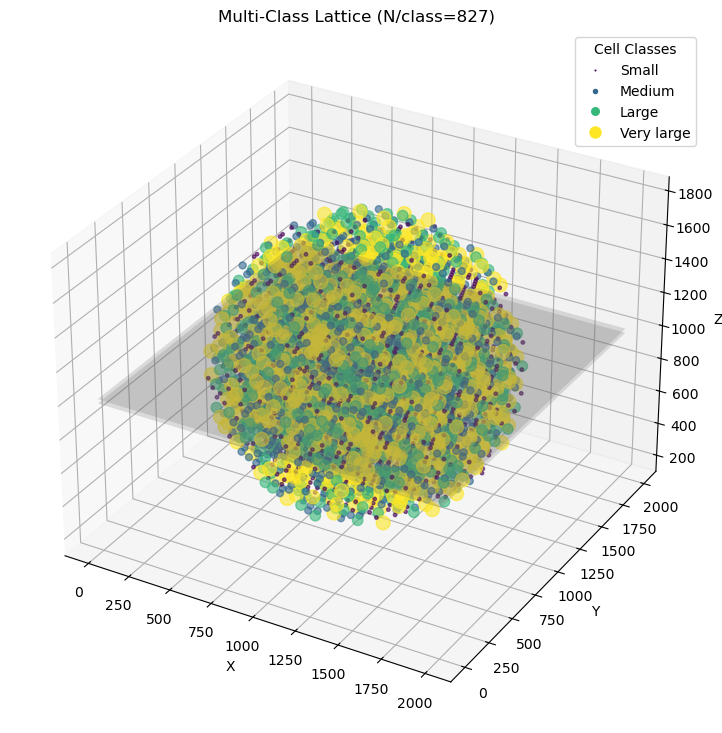

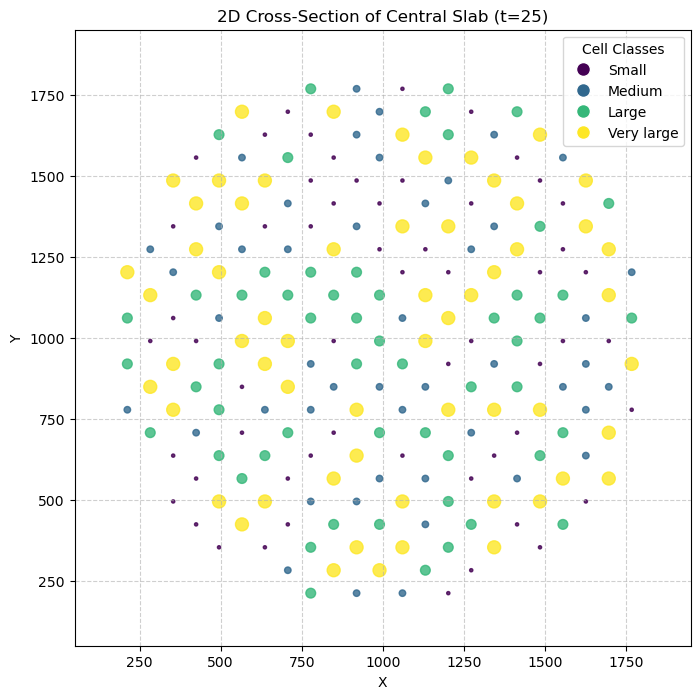

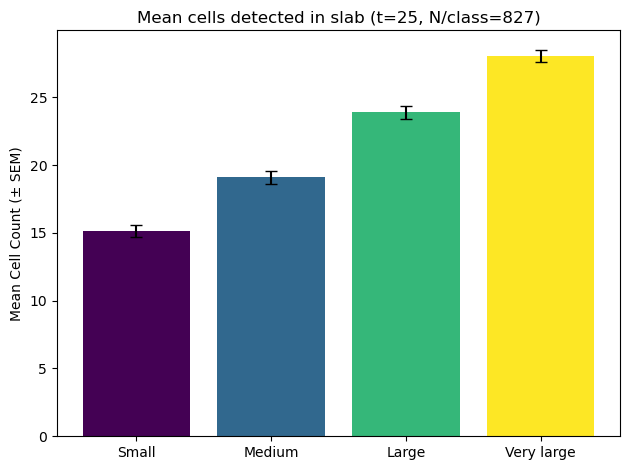

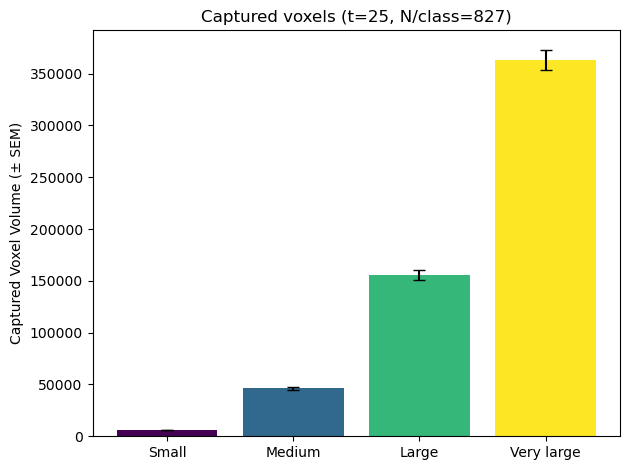

      Small | count=15.14±0.463 | voxels=5799.1±207.42
     Medium | count=19.09±0.479 | voxels=46231.3±1519.48
      Large | count=23.90±0.486 | voxels=155962.9±4661.61
 Very large | count=28.04±0.470 | voxels=363493.0±9693.44


In [31]:
"""
Equal-count, constant-per-run multiclass FCC simulation within a SPHERE.

This script simulates the detection of different-sized spherical cells in a
single-thickness slab by counting the number of intersected cells.

Key features:
- The slab is positioned at a new random z-coordinate for each run to
  ensure uniform sampling across the entire volume.
- Each class gets the SAME number of cells via the "always-safe core" method.
- Error bars on plots represent the Standard Error of the Mean (SEM).

Plots:
1) 3D scatter plot of the full multi-class lattice.
2) 2D top-down plot of the cells intersected by the central slab.
3) Mean cell count per class (bar chart with SEM).
4) Total captured voxel volume per class (bar chart with SEM).
"""

import numpy as np
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

# ----------------- Configuration dataclasses -----------------

@dataclass
class VolumeConfig:
    Lx: float = 2000.0
    Ly: float = 2000.0
    Lz: float = 2000.0
    lattice_radius: float = 950.0

@dataclass
class ClassSpec:
    name: str
    radius: float

@dataclass
class MultiClassMix:
    classes: list
    gap_kR: float = 0.0

# ----------------- FCC lattice helpers -----------------

def fcc_lattice_constant_for_Rmax(Rmax: float, gap_kR: float = 0.0) -> float:
    return math.sqrt(2.0) * (2.0 + gap_kR) * Rmax

def build_fcc_sites(vol: VolumeConfig, a: float) -> np.ndarray:
    """Generate FCC lattice sites inside a large sphere."""
    nx = int(math.ceil(vol.Lx / a)) + 1
    ny = int(math.ceil(vol.Ly / a)) + 1
    nz = int(math.ceil(vol.Lz / a)) + 1

    bases = np.array([[0,0,0], [0,a/2,a/2], [a/2,0,a/2], [a/2,a/2,0]], dtype=float)
    gx, gy, gz = np.arange(nx)*a, np.arange(ny)*a, np.arange(nz)*a

    pts = [bases + np.array([x,y,z]) for x in gx for y in gy for z in gz]
    centers = np.concatenate(pts, axis=0)

    lattice_center = np.array([vol.Lx/2, vol.Ly/2, vol.Lz/2])
    dist_sq = np.sum((centers - lattice_center)**2, axis=1)
    return centers[dist_sq <= vol.lattice_radius**2]

# ----------------- Sphere-slab intersection -----------------

def sphere_slab_intersection_volume(zc: np.ndarray, R: np.ndarray, z0: float, t: float) -> np.ndarray:
    """Vectorized sphere–slab intersection volume."""
    l, u = np.maximum(z0, zc - R), np.minimum(z0 + t, zc + R)
    valid = u > l
    vol = np.zeros_like(R, dtype=float)
    if np.any(valid):
        vol[valid] = math.pi * (R[valid]**2 * (u[valid]-l[valid]) -
                                ((u[valid]-zc[valid])**3 - (l[valid]-zc[valid])**3)/3.0)
    return vol

# ----------------- Core selection with equal class counts -----------------

def select_equal_counts_core(vol: VolumeConfig, mix: MultiClassMix,
                             max_shift_frac_xy: float, max_shift_frac_z: float):
    """Select an 'always safe' spherical core and partition it for each class."""
    Rmax = max(c.radius for c in mix.classes)
    a = fcc_lattice_constant_for_Rmax(Rmax, gap_kR=mix.gap_kR)
    sites = build_fcc_sites(vol, a)

    max_dx, max_dy = max_shift_frac_xy * a, max_shift_frac_xy * a
    max_dz = max_shift_frac_z * (a / 2.0)
    max_shift_dist = np.sqrt(max_dx**2 + max_dy**2 + max_dz**2)

    lattice_center = np.array([vol.Lx/2, vol.Ly/2, vol.Lz/2])
    dist_from_center = np.linalg.norm(sites - lattice_center, axis=1)
    safe_radius = vol.lattice_radius - Rmax - max_shift_dist
    safe_idx = np.where(dist_from_center <= safe_radius)[0]

    if safe_idx.size == 0: raise RuntimeError("No safe lattice sites found.")

    n_classes = len(mix.classes)
    np.random.default_rng(123).shuffle(safe_idx)
    N_per = safe_idx.size // n_classes
    if N_per == 0: raise RuntimeError("Not enough safe sites for one per class.")

    chunks = [safe_idx[i*N_per:(i+1)*N_per] for i in range(n_classes)]
    centers_list, radii_list, labels_list = [], [], []
    for ci, cls in enumerate(mix.classes):
        idx = chunks[ci]
        centers_list.append(sites[idx])
        radii_list.append(np.full(idx.size, cls.radius))
        labels_list.append(np.full(idx.size, ci, dtype=int))

    return (np.vstack(centers_list), np.concatenate(radii_list),
            np.concatenate(labels_list), N_per)

# ----------------- Simulation for one thickness -----------------

def simulate_equal_counts_single_thickness(vol: VolumeConfig, mix: MultiClassMix,
                                           t_slab: float, K: int = 200, seed: int = 0,
                                           max_shift_frac_xy: float = 0.5,
                                           max_shift_frac_z: float = 0.5):
    """Run simulation by moving the slab to a random z-position in each run."""
    rng = np.random.default_rng(seed)
    centers_base, radii_base, labels_base, N_per = \
        select_equal_counts_core(vol, mix, max_shift_frac_xy, max_shift_frac_z)

    n_classes = len(mix.classes)
    count_runs, vox_runs = [[] for _ in range(n_classes)], [[] for _ in range(n_classes)]
    
    z_center = vol.Lz / 2.0
    z_sphere_min, z_sphere_max = z_center - vol.lattice_radius, z_center + vol.lattice_radius
    z0_sample_min, z0_sample_max = z_sphere_min - t_slab, z_sphere_max
    
    centers, zc = centers_base, centers_base[:, 2]
    sqrt_K = np.sqrt(K)

    for _ in range(K):
        z0 = rng.uniform(z0_sample_min, z0_sample_max)
        inter = (zc + radii_base > z0) & (zc - radii_base < z0 + t_slab)
        vols = np.zeros_like(radii_base)
        if np.any(inter):
            vols[inter] = sphere_slab_intersection_volume(zc[inter], radii_base[inter], z0, t_slab)

        for j in range(n_classes):
            m_class = (labels_base == j)
            count_runs[j].append((inter & m_class).sum())
            vox_runs[j].append(vols[m_class].sum())

    # --- MODIFIED: Return SEM (Standard Error of Mean) instead of STD ---
    return {
        "class_names": [c.name for c in mix.classes],
        "count_mean": np.array([np.mean(c) for c in count_runs]),
        "count_sem": np.array([np.std(c, ddof=1) / sqrt_K for c in count_runs]),
        "vox_mean": np.array([np.mean(v) for v in vox_runs]),
        "vox_sem": np.array([np.std(v, ddof=1) / sqrt_K for v in vox_runs]),
        "t_slab": t_slab, "K": K, "N_per_class": N_per,
        "centers_base": centers_base, "labels_base": labels_base, "radii_base": radii_base
    }

# ----------------- Example usage & plots -----------------

if __name__ == "__main__":
    vol = VolumeConfig(2000.0, 2000.0, 2000.0, lattice_radius=950.0)
    classes = [
        ClassSpec("Small", 5.0), ClassSpec("Medium", 10.0),
        ClassSpec("Large", 15.0), ClassSpec("Very large", 20.0),
    ]
    mix = MultiClassMix(classes=classes, gap_kR=3.0)
    t_slab = 25.0

    res = simulate_equal_counts_single_thickness(
        vol, mix, t_slab, K=2000, seed=123
    )

    centers, labels, radii = res["centers_base"], res["labels_base"], res["radii_base"]
    class_colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
    
    # --- 3D Scatter Plot ---
    fig_3d = plt.figure(figsize=(9, 9))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    size_scale_factor = 0.5 
    point_sizes = (radii * size_scale_factor)**2
    point_colors = [class_colors[l] for l in labels]
    ax_3d.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                  s=point_sizes, c=point_colors, alpha=0.6)

    z_center_vis = vol.Lz / 2.0
    xx, yy = np.meshgrid(np.linspace(0, vol.Lx, 2), np.linspace(0, vol.Ly, 2))
    ax_3d.plot_surface(xx, yy, np.full_like(xx, z_center_vis - t_slab/2), color='grey', alpha=0.2)
    ax_3d.plot_surface(xx, yy, np.full_like(xx, z_center_vis + t_slab/2), color='grey', alpha=0.2)
    
    legend_elements_3d = [Line2D([0], [0], marker='o', color='w', label=cls.name,
                           markerfacecolor=class_colors[i], markersize=np.sqrt(point_sizes[labels==i][0]))
                           for i, cls in enumerate(classes)]
    ax_3d.legend(handles=legend_elements_3d, title="Cell Classes")
    ax_3d.set_xlabel('X'); ax_3d.set_ylabel('Y'); ax_3d.set_zlabel('Z')
    ax_3d.set_title(f'Multi-Class Lattice (N/class={res["N_per_class"]})')
    ax_3d.set_aspect('equal', adjustable='box')

    # --- 2D Cross-Section Plot ---
    fig_2d, ax_2d = plt.subplots(figsize=(8, 8))
    z0, z1 = z_center_vis - t_slab/2.0, z_center_vis + t_slab/2.0
    intersect_mask = (centers[:, 2] + radii > z0) & (centers[:, 2] - radii < z1)
    
    for i in range(len(centers)):
        if intersect_mask[i]:
            circle = Circle(centers[i, :2], radii[i],
                            color=class_colors[labels[i]], alpha=0.8)
            ax_2d.add_patch(circle)

    ax_2d.set_aspect('equal'); ax_2d.grid(True, linestyle='--', alpha=0.6)
    ax_2d.set_xlim(z_center_vis - vol.lattice_radius, z_center_vis + vol.lattice_radius)
    ax_2d.set_ylim(z_center_vis - vol.lattice_radius, z_center_vis + vol.lattice_radius)
    ax_2d.set_xlabel('X'); ax_2d.set_ylabel('Y')
    ax_2d.set_title(f'2D Cross-Section of Central Slab (t={t_slab:.0f})')
    legend_elements_2d = [Line2D([0], [0], marker='o', color='w', label=cls.name,
                           markerfacecolor=class_colors[i], markersize=10)
                           for i, cls in enumerate(classes)]
    ax_2d.legend(handles=legend_elements_2d, title="Cell Classes")
    
    # --- MODIFIED: Bar plot 1 uses SEM for error bars ---
    x = np.arange(len(res["class_names"]))
    plt.figure()
    plt.bar(x, res["count_mean"], yerr=res["count_sem"], capsize=4, color=class_colors)
    plt.xticks(x, res["class_names"])
    plt.ylabel("Mean Cell Count (± SEM)")
    plt.title(f"Mean cells detected in slab (t={res['t_slab']:.0f}, N/class={res['N_per_class']})")
    plt.tight_layout()

    # --- MODIFIED: Bar plot 2 uses SEM for error bars ---
    plt.figure()
    plt.bar(x, res["vox_mean"], yerr=res["vox_sem"], capsize=4, color=class_colors)
    plt.xticks(x, res["class_names"]); plt.ylabel("Captured Voxel Volume (± SEM)")
    plt.title(f"Captured voxels (t={res['t_slab']:.0f}, N/class={res['N_per_class']})")
    plt.tight_layout()

    plt.show()

    # --- MODIFIED: Textual summary uses SEM ---
    for i, name in enumerate(res["class_names"]):
        print(f"{name:>11s} | count={res['count_mean'][i]:.2f}±{res['count_sem'][i]:.3f} "
              f"| voxels={res['vox_mean'][i]:.1f}±{res['vox_sem'][i]:.2f}")